# Train model to recognise voice of people 

In [49]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [50]:
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
                    ToMelSpectrogramTransform(
                        sample_rate=sample_rate, n_mels=64, n_fft=512)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        spectrogram = spectrogram.unsqueeze(0)
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [51]:
class DS(CombinedSoundDS):
    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(0 if label else 1, dtype=torch.int64)

In [52]:

DATASET_PATH = './dataset/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'
SAMPLE_RATE = 16000

In [53]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AirAbsorptionWrapperTransform(),
		EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AirAbsorptionWrapperTransform(),
		EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [54]:
train_df = pd.read_csv(DATASET_PATH + "train_combined_dataset.csv")
train_ds = DS(train_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = DS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

In [55]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*64*188, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [56]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [57]:

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


def evaluate_siamese_model_contrast_loss(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
			loss = criterion(anchor_output, posneg_output, label)
			total_loss += loss.item()

			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss

In [58]:
def train_siamese_model_contrast_loss(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		optimizer.zero_grad()
		anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
		loss = criterion(anchor_output, posneg_output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		true_labels += [label.item() for label in label.cpu()]

	avg_loss = total_loss / len(dataloader)
	
	return avg_loss

In [59]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [60]:
num_epochs = 4
siamese_model = SiameseNetwork().to('cuda')
criterion = ContrastiveLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss = train_siamese_model_contrast_loss(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}")
	_test_loss = evaluate_siamese_model_contrast_loss(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}")
	loss.append([_train_loss, _test_loss])

KeyboardInterrupt: 

In [ ]:
def save_model(model, model_name, base_path = './model_save/'):
	model.cpu()
	model.eval()
	torch.save(model, base_path + model_name)

In [ ]:
save_model(siamese_model, "contrast_cnn.pt")

In [ ]:
from matplotlib import pyplot as plt


def plot_siamese_model(anchor_sgram, posneg_sgram, label, loss):
	plt.style.use("dark_background")
	plt.figure(figsize=(10, 2), facecolor="#1e1e1e")
	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	type = "Positive" if label.item() == 0 else "Negative"
	plt.title(f"{type} Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.show()
	print(f"Similarity: {loss}")

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate(model, anchor_sgram, posneg_sgram, label):
	model.eval()
	model.to(device)
	with torch.no_grad():
		anchor_sgram = anchor_sgram.unsqueeze(0).to(device)
		posneg_sgram = posneg_sgram.unsqueeze(0).to(device)
		label = label.to(device)
		anchor_output, posneg_output = model(anchor_sgram, posneg_sgram)
		loss = criterion(anchor_output, posneg_output, label)
	label.cpu()
	return loss.item()

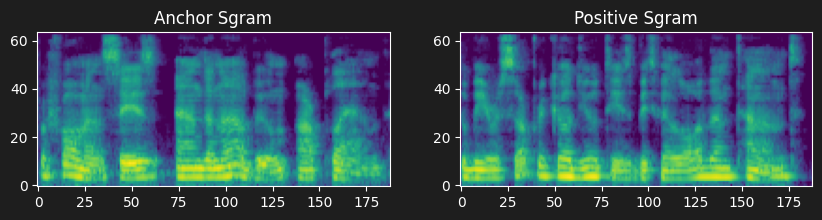

Similarity: 0.2060549259185791


In [ ]:
anchor_sgram, posneg_sgram, label = train_ds[0]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

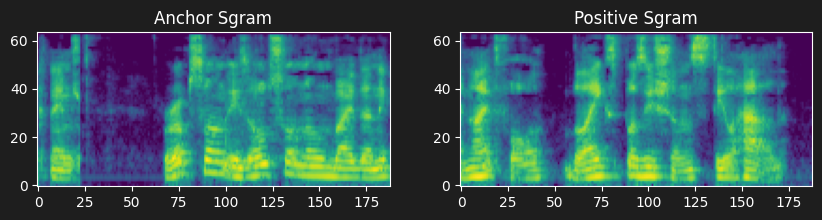

Similarity: 0.20283623039722443


In [ ]:
anchor_sgram, posneg_sgram, label = train_ds[5]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

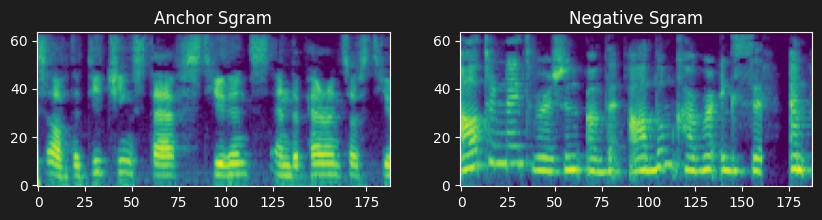

Similarity: 0.214181050658226


In [ ]:
anchor_sgram, posneg_sgram, label = test_ds[5]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)

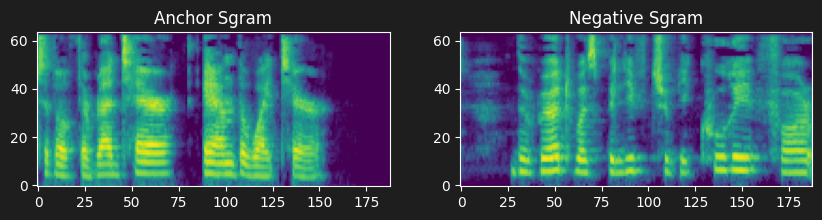

Similarity: 0.26636677980422974


In [ ]:
anchor_sgram, posneg_sgram, label = test_ds[1]
loss = evaluate(siamese_model, anchor_sgram, posneg_sgram, label)
plot_siamese_model(anchor_sgram.squeeze(0), posneg_sgram.squeeze(0), label, loss)